# Load Training Data

In [1]:
%load_ext autoreload
%autoreload 2
# https://pykoopman.readthedocs.io/en/master/tutorial_koopman_edmdc_for_vdp_system.html

In [18]:
from robot_tools.trajer import TrajTools, recorder, TrajsPainter, TrajInfo

data = recorder.json_process("trajs_recorder_0211_17.json")

(obs_trajs, raw_state_info) = TrajTools.construct_trajs(
    data, "observation", series_type="h", mixed_type="h", show_info=True
)

(act_trajs, raw_act_info) = TrajTools.construct_trajs(
    data, "action", series_type="h", mixed_type="h", show_info=True
)

# ? 为什么突然要指明类型了？
raw_state_info:TrajInfo
raw_act_info:TrajInfo

# Training data
RAW_STATE_MIXED = obs_trajs[2][:2,:]
RAW_ACTION_MIXED = act_trajs[2]
RAW_STATE_SERIES = obs_trajs[1][:2,:]
RAW_ACTION_SERIES = act_trajs[1]
assert RAW_STATE_MIXED.shape == RAW_ACTION_MIXED.shape
assert RAW_ACTION_SERIES.shape == RAW_STATE_SERIES.shape

observation trajectories number:  1
observation each points number:  [1000.]
observation points dim:  3
action trajectories number:  1
action each points number:  [1000.]
action points dim:  2


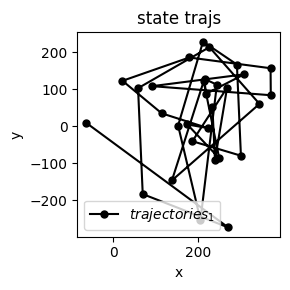

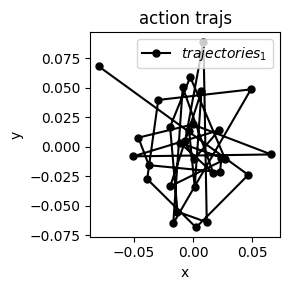

[[ -62.4921875   270.0369873    69.5          58.5       ]
 [   8.22503662 -274.21795654 -184.          102.5       ]]
[[-0.07953719  0.04676094  0.00263141 -0.03870455]
 [ 0.06794114 -0.02397263 -0.06852562 -0.02747946]]


In [19]:
# draw 2D raw data
show_points_num = 30
raw_state_painter = TrajsPainter(RAW_STATE_MIXED, raw_state_info)
raw_state_painter.figure_size_2D = (3, 3)
raw_state_painter.features_axis_labels = ["x", "y", "yaw"]
raw_state_painter.plot_2D_features((0, show_points_num), (0,), (0, 1), title="state trajs")
raw_act_painter = TrajsPainter(RAW_ACTION_MIXED, raw_act_info)
raw_act_painter.figure_size_2D = (3, 3)
raw_act_painter.features_axis_labels = ["x", "y", "yaw"]
raw_act_painter.plot_2D_features((0, show_points_num), (0,), (0, 1), title="action trajs")

print(RAW_STATE_SERIES[:, 0:4])
print(RAW_ACTION_SERIES[:, 0:4])
# print(RAW_STATE_MIXED[:, 0:4])
# print(RAW_ACTION_MIXED[:, 0:4])

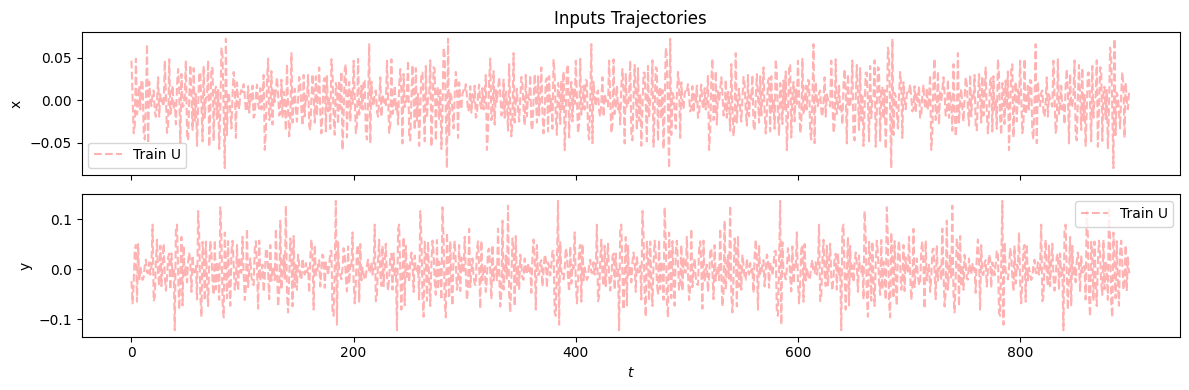

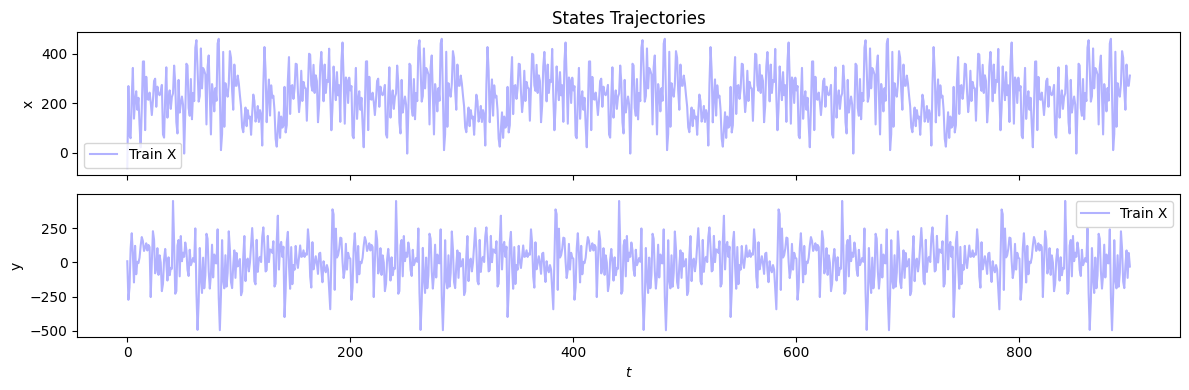

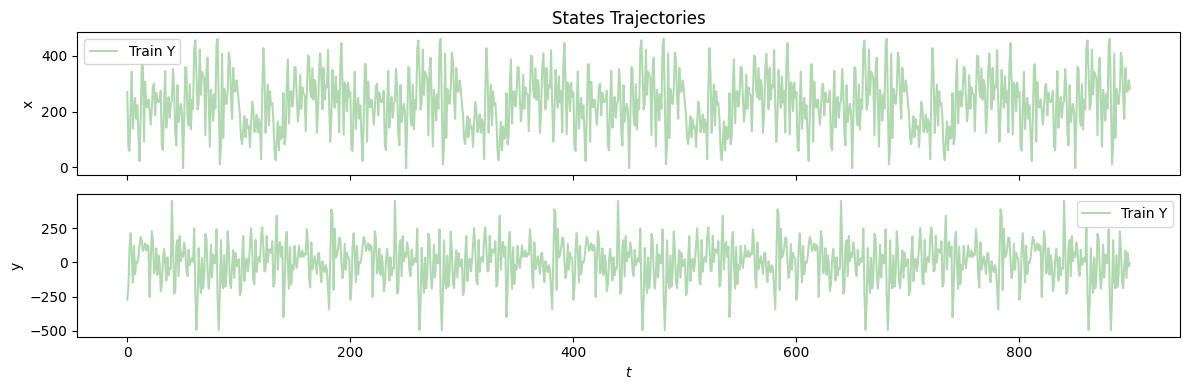

In [20]:
# draw 1D X Y U data
points_num = 900
start_point = 0
end_point = int(start_point + points_num)
trajs = (0,)
assert end_point <= raw_state_info.each_points_num[0]
raw_state_info.points_dim = 2
raw_act_info.points_dim = 2

X, X_info = TrajTools.get_sub_series_trajs(
    RAW_STATE_SERIES, raw_state_info, (start_point, end_point), trajs
)
Y, Y_info = TrajTools.get_sub_series_trajs(
    RAW_STATE_SERIES,
    raw_state_info,
    (start_point + 1, end_point + 1),
    trajs,
)
U, U_info = TrajTools.get_sub_series_trajs(
    RAW_ACTION_SERIES,
    raw_act_info,
    (start_point + 1, end_point + 1),
    trajs,
)

u_painter = TrajsPainter(U, U_info)
u_painter.features_sharetitle = "Inputs Trajectories"
u_painter.features_self_labels = "Train U"
u_painter.features_lines = "--r"
u_painter.features_axis_labels = ["x", "y", "yaw"]
u_painter.plot_features_with_t((0, points_num), (0,), (0, 1))

x_painter = TrajsPainter(X, X_info)
x_painter.features_sharetitle = "States Trajectories"
x_painter.features_self_labels = "Train X"
x_painter.features_lines = "-b"
x_painter.features_axis_labels = ["x", "y", "yaw"]
x_painter.plot_features_with_t((0, points_num), (0,), (0, 1))

y_painter = TrajsPainter(Y, Y_info)
y_painter.features_sharetitle = "States Trajectories"
y_painter.features_self_labels = "Train Y"
y_painter.features_lines = "-g"
y_painter.features_axis_labels = ["x", "y", "yaw"]
y_painter.plot_features_with_t((0, points_num), (0,), (0, 1))

# Koopman using EDMDc

## Training

In [5]:
import pykoopman as pk
import warnings
import numpy as np
np.random.seed(42)  # for reproducibility
warnings.filterwarnings("ignore")
from pykoopman.regression import EDMDc
from pykoopman.observables import RadialBasisFunction, Polynomial

In [45]:
EDMDc_ = EDMDc()

"""径向基方法"""
# 收敛拟合
# rbf_type = "thinplate"  # 'thinplate' polyharmonic gauss invquad invmultquad
# regressor = RadialBasisFunction(
#     rbf_type=rbf_type,
#     n_centers=10,
#     centers=None,
#     kernel_width=1.0,
#     polyharmonic_coeff=2.0,
#     include_state=True,
# )
# 发散拟合
# EDMDc_ = EDMDc()
# centers = np.random.uniform(-1,1,(2,5))
# regressor = RadialBasisFunction(
#     rbf_type="thinplate",
#     n_centers=centers.shape[1],
#     centers=centers,
#     kernel_width=1,
#     polyharmonic_coeff=1,
#     include_state=True,
# )
# test
# rbf_type = "polyharmonic"  # 'thinplate' polyharmonic gauss invquad invmultquad
# regressor = RadialBasisFunction(
#     rbf_type=rbf_type,
#     n_centers=10,
#     centers=None,
#     kernel_width=1.0,
#     polyharmonic_coeff=2.0,
#     include_state=True,
# )
"""多项式方法"""
# 良好拟合
# regressor = Polynomial(degree=2)
# 错误拟合
regressor = Polynomial(degree=2, include_bias=True, interaction_only=True)

model = pk.Koopman(observables=regressor, regressor=EDMDc_)
model.fit(X.T, y=Y.T, u=U.T)



Koopman(observables=Polynomial(interaction_only=True), regressor=EDMDc())

In [27]:
print(model.A), print("")
print(model.B), print("")
print(model.C), print("")
print(model.W), print("")

[[ 9.99999999e-01  3.65738290e-12  7.71214275e-14  1.58192842e-16]
 [ 1.61509166e+02  3.03577381e-01  1.69565913e-01 -2.05989434e-04]
 [ 1.04251588e+02 -4.28959029e-01  8.76702864e-02  2.71856155e-04]
 [ 2.42074410e+04 -1.02563724e+02  6.05486746e+01 -1.40328202e-01]]

[[-4.15485917e-09  2.38336128e-09]
 [ 1.50790992e+03  9.71208218e+02]
 [-2.16117318e+03  1.60490965e+03]
 [-5.09602538e+05  3.80849666e+05]]

[[0. 1. 0. 0.]
 [0. 0. 1. 0.]]

[[ 3.97965854e-01+0.j          9.22452686e-04+0.00223392j
   9.22452686e-04-0.00223392j  4.81483331e-04+0.j        ]
 [ 8.37535174e-03+0.j         -4.50587196e-03+0.00017982j
  -4.50587196e-03-0.00017982j -2.24486020e-04+0.j        ]]



(None, None)

In [46]:
# 在训练集上回归
# 这里因为只有一个轨迹，所以采用了简化的方式
Xtrain = X
x0 = X[:, 0]

print(x0.shape)
print(U.shape)

points_num = 90
Xkoop = model.simulate(x0, U.T[:points_num,:], n_steps=points_num - 1)
Xkoop = np.vstack([x0, Xkoop])  # add initial point
Xkoop = Xkoop.T

(2,)
(2, 90)


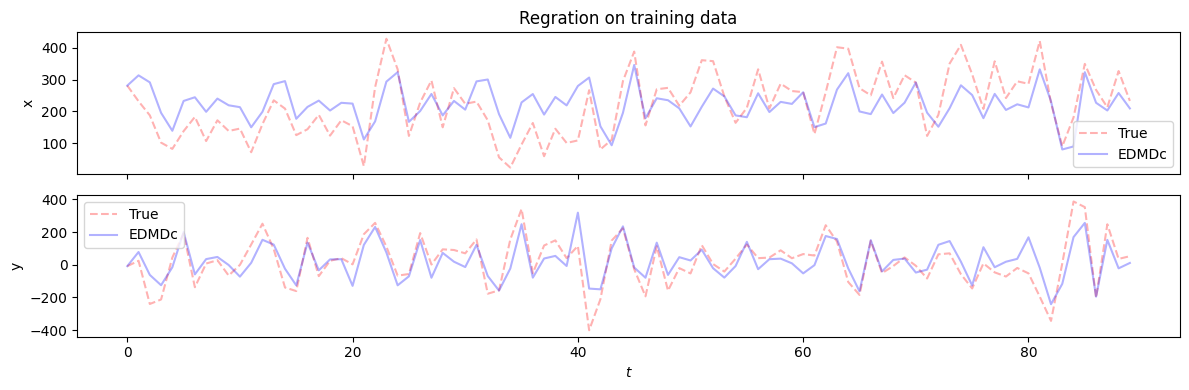

In [47]:
# 绘图
from robot_tools.trajer import TrajInfo

max_train_draw = 90
Xkoop_info = Xtrain_info = TrajInfo.consruct(
    Xtrain,
    "series_h",
    1,
)

trajs_painter = TrajsPainter()
trajs_painter.update_trajs(Xtrain, Xtrain_info)
trajs_painter.features_self_labels = "True"
trajs_painter.features_lines = "--r"
trajs_painter.features_sharetitle = "Regration on training data"
trajs_painter.features_axis_labels = ["x", "y", "yaw"]
axis = trajs_painter.plot_features_with_t(
    (0, max_train_draw), (0,), (0, 1), return_axis=True
)

trajs_painter.update_trajs(Xkoop, Xkoop_info)
trajs_painter.features_self_labels = "EDMDc"
trajs_painter.features_lines = "-b"
trajs_painter.plot_features_with_t((0, max_train_draw), (0,), (0, 1), given_axis=axis)

## Testing

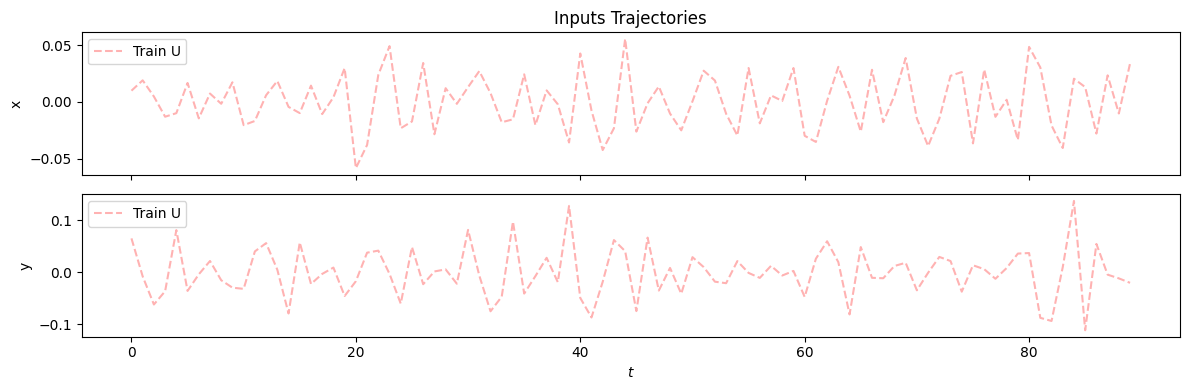

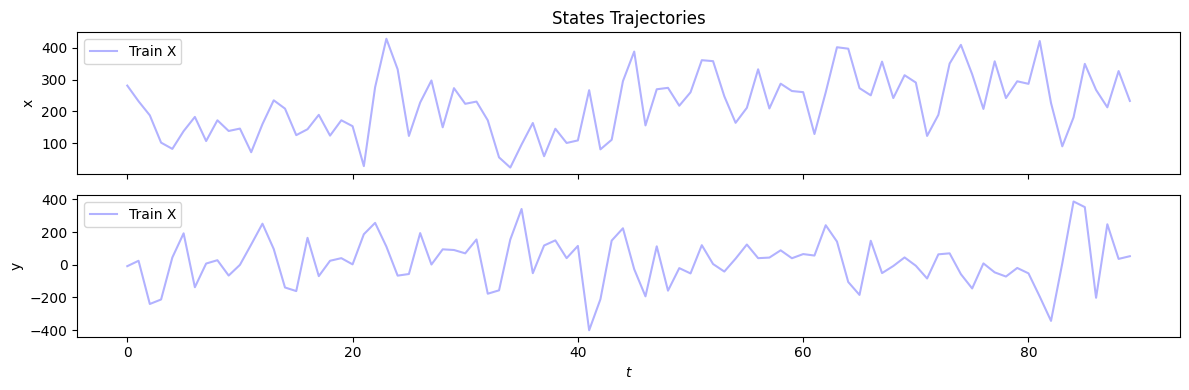

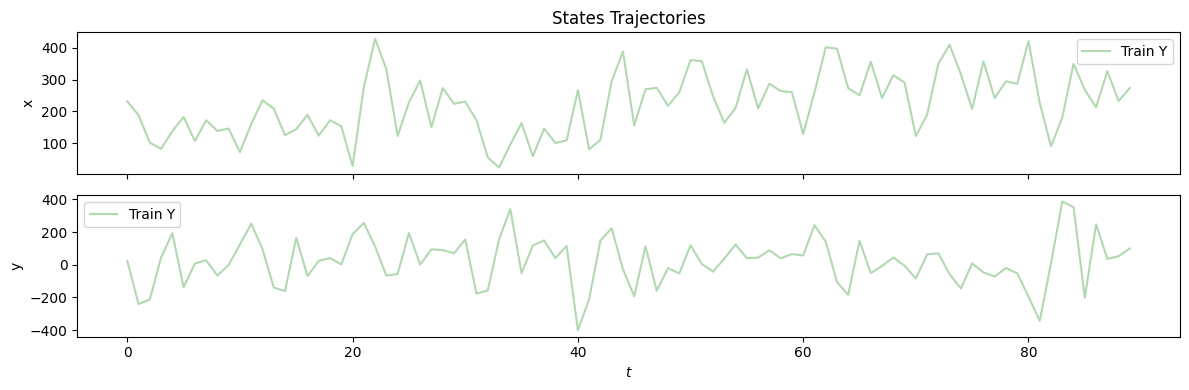

In [30]:
# draw 1D X Y U data
points_num = 90
start_point = 900
end_point = int(start_point + points_num)
trajs = (0,)
assert end_point <= raw_state_info.each_points_num[0]
raw_state_info.points_dim = 2
raw_act_info.points_dim = 2

X, X_info = TrajTools.get_sub_series_trajs(
    RAW_STATE_SERIES, raw_state_info, (start_point, end_point), trajs
)
Y, Y_info = TrajTools.get_sub_series_trajs(
    RAW_STATE_SERIES,
    raw_state_info,
    (start_point + 1, end_point + 1),
    trajs,
)
U, U_info = TrajTools.get_sub_series_trajs(
    RAW_ACTION_SERIES,
    raw_act_info,
    (start_point + 1, end_point + 1),
    trajs,
)

u_painter = TrajsPainter(U, U_info)
u_painter.features_sharetitle = "Inputs Trajectories"
u_painter.features_self_labels = "Train U"
u_painter.features_lines = "--r"
u_painter.features_axis_labels = ["x", "y", "yaw"]
u_painter.plot_features_with_t((0, points_num), (0,), (0, 1))

x_painter = TrajsPainter(X, X_info)
x_painter.features_sharetitle = "States Trajectories"
x_painter.features_self_labels = "Train X"
x_painter.features_lines = "-b"
x_painter.features_axis_labels = ["x", "y", "yaw"]
x_painter.plot_features_with_t((0, points_num), (0,), (0, 1))

y_painter = TrajsPainter(Y, Y_info)
y_painter.features_sharetitle = "States Trajectories"
y_painter.features_self_labels = "Train Y"
y_painter.features_lines = "-g"
y_painter.features_axis_labels = ["x", "y", "yaw"]
y_painter.plot_features_with_t((0, points_num), (0,), (0, 1))

In [31]:
# 在训练集上回归
# 这里因为只有一个轨迹，所以采用了简化的方式
Xtrain = X
x0 = X[:, 0]

print(x0.shape)
print(U.shape)

Xkoop = model.simulate(x0, U.T[:points_num,:], n_steps=points_num - 1)
Xkoop = np.vstack([x0, Xkoop])  # add initial point
Xkoop = Xkoop.T

(2,)
(2, 90)


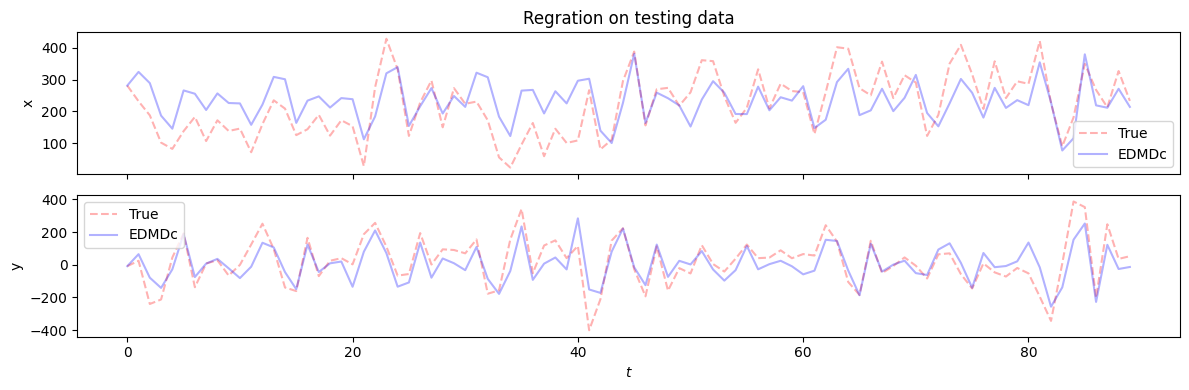

In [32]:
# 绘图
from robot_tools.trajer import TrajInfo

max_train_draw = 90
Xkoop_info = Xtrain_info = TrajInfo.consruct(
    Xtrain,
    "series_h",
    1,
)

trajs_painter = TrajsPainter()
trajs_painter.update_trajs(Xtrain, Xtrain_info)
trajs_painter.features_self_labels = "True"
trajs_painter.features_lines = "--r"
trajs_painter.features_sharetitle = "Regration on testing data"
trajs_painter.features_axis_labels = ["x", "y", "yaw"]
axis = trajs_painter.plot_features_with_t(
    (0, max_train_draw), (0,), (0, 1), return_axis=True
)

trajs_painter.update_trajs(Xkoop, Xkoop_info)
trajs_painter.features_self_labels = "EDMDc"
trajs_painter.features_lines = "-b"
trajs_painter.plot_features_with_t((0, max_train_draw), (0,), (0, 1), given_axis=axis)

In [33]:
err = np.linalg.norm(Xtrain - Xkoop)
print(f"Error: {err:.2f}")

Error: 1071.12


In [ ]:
from robot_tools.trajer import TrajTools, recorder, TrajsPainter

data = recorder.json_process("data_sim_1.json")

(obs_trajs, raw_state_info) = TrajTools.construct_trajs(
    data, key="observation", series_type="h", mixed_type="h"
)

(act_trajs, raw_act_info) = TrajTools.construct_trajs(
    data, key="action", series_type="h", mixed_type="h"
)

print("Number of trajectories: ", raw_state_info.trajs_num)
print("Number of states: ", raw_state_info.features_num)
print("Number of inputs: ", raw_act_info.features_num)
print("Number of each points: ", raw_state_info.each_points_num)

# Training data
RAW_STATE_MIXED = obs_trajs[2]
RAW_ACTION_MIXED = act_trajs[2]
RAW_STATE_SERIES = obs_trajs[1][:2,:]
RAW_ACTION_SERIES = act_trajs[1][:2,:]
assert RAW_STATE_MIXED.shape == RAW_ACTION_MIXED.shape
assert RAW_ACTION_SERIES.shape == RAW_STATE_SERIES.shape

print(RAW_STATE_SERIES[:, 0:4])
print(RAW_ACTION_SERIES[:, 0:4])

points_num = 15
start_point = 0
end_point = int(start_point + points_num)
trajs = (0,)
assert end_point <= raw_state_info.each_points_num[0]
raw_state_info.features_num = 2
raw_act_info.features_num = 2
X_test, X_test_info = TrajTools.get_sub_series_trajs(
    RAW_STATE_SERIES, raw_state_info, (start_point, end_point), trajs
)
Y_test, Y_test_info = TrajTools.get_sub_series_trajs(
    RAW_STATE_SERIES,
    raw_state_info,
    (start_point + 1, int(start_point + points_num) + 1),
    trajs,
)
U_test, U_test_info = TrajTools.get_sub_series_trajs(
    RAW_ACTION_SERIES,
    raw_act_info,
    (start_point + 1, int(start_point + points_num) + 1),
    trajs,
)

show_points_num = points_num
trajs_painter = TrajsPainter()
trajs_painter.update_trajs(X_test, X_test_info)
trajs_painter.features_sharetitle = "States Trajectories"
trajs_painter.features_self_labels = "Test X"
trajs_painter.features_lines = "--r"
trajs_painter.features_axis_labels = ["x", "y", "yaw"]
trajs_painter.plot_features_with_t((0, show_points_num), (0,), (0, 1))
u_painter = TrajsPainter(U_test, U_test_info)
u_painter.features_sharetitle = "Inputs Trajectories"
u_painter.features_self_labels = "Test U"
u_painter.features_lines = "--r"
u_painter.features_axis_labels = ["x", "y", "yaw"]
u_painter.plot_features_with_t((0, show_points_num), (0,), (0, 1))

test_painter = TrajsPainter(X_test, X_test_info)
test_painter.trajs_labels = "Test X"
test_painter.features_axis_labels = ["x", "y", "yaw"]
axis = test_painter.plot_2D_features((0, show_points_num), (0,), (0, 1), return_axs=True)
test_painter.update_trajs(Y_test, Y_test_info)
test_painter.trajs_labels = "Test Y"
test_painter.trajs_lines = "->r"
test_painter.trajs_markersize = 3
test_painter.plot_2D_features((0, show_points_num), (0,), (0, 1), given_axs=axis)

In [ ]:
# 在测试集上预测
n_traj = 1
x = X_test[:, 0][np.newaxis, :]
Xk = X_test_info.get_trajs("mixed_h")
Yk = X_test_info.get_trajs("mixed_h")

for k in range(int(X_test_info.max_points_num)):
    yT = model.predict(x, U_test[:, k])
    Xk[:, k * n_traj : (k + 1) * n_traj] = x.T
    Yk[:, k * n_traj : (k + 1) * n_traj] = yT.T
    x = yT
assert TrajTools.has_nan(Xk) == False, "Xk has nan"
assert TrajTools.has_nan(Yk) == False, "Yk has nan"
print(X_test[:, 0:3])
print(Xk[:, 0:3])

In [ ]:
show_points_num = 15
trajs_painter = TrajsPainter()
trajs_painter.update_trajs(X_test, X_test_info)
trajs_painter.features_self_labels = "True Test"
trajs_painter.features_lines = "--r"
trajs_painter.features_sharetitle = "Prediciton on test data"
trajs_painter.features_axis_labels = ["x", "y", "yaw"]
axis = trajs_painter.plot_features_with_t(
    (0, show_points_num), (0,), (0, 1), return_axs=True
)

trajs_painter.update_trajs(Xk, X_test_info)
trajs_painter.features_self_labels = "Koopman Test"
trajs_painter.features_lines = "-b"
trajs_painter.plot_features_with_t((0, show_points_num), (0,), (0, 1), given_axs=axis)
# trajs_painter.plot_features_with_t((0, 7), (0,), (0, 1, 2), given_axs=axs)

# 2D轨迹绘制

## Training

In [ ]:
train_points_num = 15
raw_state_painter = TrajsPainter()
raw_state_painter.update_trajs(Xtrain, Xtrain_info)
raw_state_painter.trajs_labels = "Training trajectories"
axis = raw_state_painter.plot_2D_features((0, train_points_num), (0,), (0, 1), return_axs=True)
raw_state_painter.update_trajs(Xkoop, Xkoop_info)
raw_state_painter.trajs_labels = "Koopman prediction on training trajectories"
raw_state_painter.trajs_lines = "->r"
raw_state_painter.trajs_markersize = 3
raw_state_painter.plot_2D_features((0, train_points_num), (0,), (0, 1), given_axs=axis)

## Testing

In [ ]:
raw_state_painter = TrajsPainter()
raw_state_painter.update_trajs(X_test, X_test_info)
raw_state_painter.trajs_labels = "Testing trajectories"
axis = raw_state_painter.plot_2D_features((0, show_points_num), (0,), (0, 1), return_axs=True)
raw_state_painter.update_trajs(Xk, X_test_info)
raw_state_painter.trajs_labels = "Koopman prediction on testing trajectories"
raw_state_painter.trajs_lines = "->r"
raw_state_painter.trajs_markersize = 3
raw_state_painter.plot_2D_features((0, show_points_num), (0,), (0, 1), given_axs=axis)